In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.1.0


# Mnist data

(60000, 28, 28)
(60000,)
(60000, 28, 28)
(6131, 28, 28)


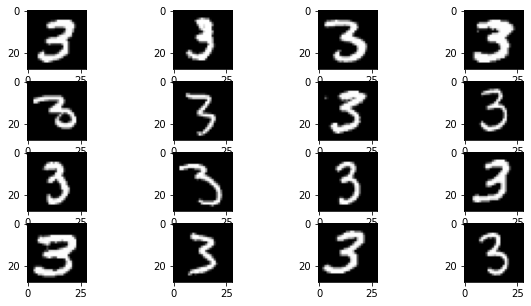

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

learn_label = 3
train_images = train_images[train_labels==learn_label]
print(train_images.shape)

fig = plt.figure(figsize=(10,5))
for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(train_images[i],cmap='gray')
plt.show()

train_images = (train_images-127.5)/127.5


# Noise

uniform 사용

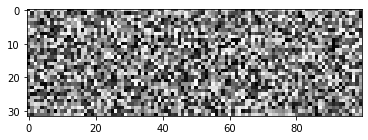

In [3]:
def create_noise(batch_size, noise_dim):
    return np.random.uniform(low=-1, high=1, size=(batch_size, noise_dim))
#     return np.random.normal(size=(batch_size, noise_dim))

noise = create_noise(32,100)
plt.imshow(noise,cmap= 'gray')
plt.show()


# Model

## Affine layer

In [4]:
def xavier(size):
    return np.random.normal(size=size, scale=np.sqrt(2/np.sum(size) ))

class DNN:
    def __init__(self, input_size, output_size):
        self.W = xavier((input_size, output_size))
        self.b = np.zeros((output_size,))
        
    def forward(self, x):
        w = self.W
        b = self.b
        
        out = x.reshape(x.shape[0], -1).dot(w) + b
        cache = (x, w, b)
        return out, cache
    
    def backward(self, dout, cache):
        x, w, b = cache
        dx = dout.dot(w.T).reshape(x.shape)
        dw = x.reshape(x.shape[0],-1).T.dot(dout)
        db = np.sum(dout, axis=0)
        
        grads = (dw, db)
        
        return dx, grads
    
    def sgd_update(self, grads, lr = 1e-3):
        dw, db = grads
    
        self.W -= lr*dw
        self.b -= lr*db

## ReLU

In [5]:
class RELU:
    def __init__(self):
        pass
    
    def forward(self, x):
        out = np.maximum(0,x)
        cache = x
        return out, cache
    
    def backward(self, dout, cache):
        x = cache
        dx = np.where(x>0, dout, 0)
        return dx

## Dropout

In [6]:
class DROPOUT:
    def __init__(self, p=0.5):
        self.p = p
    
    def forward(self, x, mode='train'):
        p = self.p
        
        mask = None
        if mode == 'train':
            mask = (np.random.rand(*x.shape) <p ) /p
            out = mask*x
        else:
            out = x
        
        cache = mask
        out = out.astype(x.dtype, copy=False)
        
        return out, cache

    def backward(self, dout, cache, mode='train'):
        mask = cache
        
        if mode=='train':
            dx = mask * dout
        else:
            dx = dout
        return dx
        

## Sigmoid

In [7]:
class SIGMOID:
    def __init__(self):
        pass
    
    def forward(self, x):
        out = 1 / (1+np.exp(-x))
        cache = out
        return out, cache
    
    def backward(self, dout, cache):
        out = cache
        return out*(1-out)*dout
    

## Generator, Discriminator

In [8]:
class Generator:
    def __init__(self,
                 noise_size=100,
                 hidden_dim=196,
                 output_size=784
                ):
        self.d1 = DNN(noise_size, hidden_dim)
        self.re1 = RELU()
        self.d2 = DNN(hidden_dim, output_size)

    def forward(self, x):
        out1, cache1 = self.d1.forward(x)
        out2, cache2 = self.re1.forward(out1)
        out3, cache3 = self.d2.forward(out2)
        
        caches = (cache1, cache2, cache3)
        
        return out3, caches
        
    def backward(self, dout, caches):
        cache1, cache2, cache3 = caches
        
        dout, grads2 = self.d2.backward(dout, cache3)
        dout = self.re1.backward(dout, cache2)
        dout, grads1 = self.d1.backward(dout, cache1)
        
        grads = (grads1, grads2)
        
        return dout, grads
    
    def sgd_update(self, grads):
        grads1, grads2 = grads
        self.d1.sgd_update(grads1)
        self.d2.sgd_update(grads2)
        


In [9]:
class Discriminator:
    def __init__(self, 
                 input_size=784,
                 hidden_dim = 200,
                 output_size=1
                ):
        
        self.d1 = DNN(input_size, hidden_dim)
        self.dr1 = DROPOUT()
        self.re1 = RELU()
        
        self.d2 = DNN(hidden_dim, output_size)
        self.sig = SIGMOID()
        
    def forward(self, x, mode='train'):
        out1, cache1 = self.d1.forward(x)
        out2, cache2 = self.dr1.forward(out1, mode)
        out3, cache3 = self.re1.forward(out2)
        
        out4, cache4 = self.d2.forward(out3)
        out5, cache5 = self.sig.forward(out4)
        
        caches = (cache1, cache2, cache3, cache4, cache5)
        
        return out5, caches
    
    def backward(self, dout, caches, mode='train'):
        cache1, cache2, cache3, cache4, cache5 = caches
        
        dout5 = self.sig.backward(dout, cache5)
        dout4, grads2 = self.d2.backward(dout5, cache4)
        
        dout3 = self.re1.backward(dout4, cache3)
        dout2 = self.dr1.backward(dout3, cache2, mode)
        dout1, grads1 = self.d1.backward(dout2, cache1)
            
        grads = (grads1, grads2)
    
        return dout1, grads
    
    def sgd_update(self, grads):
        grads1, grads2 = grads
        self.d1.sgd_update(grads1)
        self.d2.sgd_update(grads2)

## LOSS

In [10]:
def binary_cross_entropy_loss(x, y):
    loss = -np.mean(y*np.log(x) + (1-y)*np.log(1-x))    
    dx = -y/(x+1e-8) + (1-y)/(1-x+1e-8)
    return loss, dx

def G_loss(fake_output):
    loss = np.mean(-np.log(fake_output))
    grad = -1./(fake_output+1e-5)
    return loss, grad
    
def D_real_loss(real_output):
    loss = np.mean(-np.log(real_output))
    grad = -1./(real_output+1e-8)
    return loss, grad

def D_fake_loss(fake_output):
    loss = np.mean(-np.log(1-fake_output))
    grad = 1./(1-fake_output+1e-8)
    return loss, grad


## Train

In [11]:
def train(G, D, train_ds, EPOCHS, 
          BATCH_SIZE=16, 
          NOISE_DIM=100,
          show=True
         ):
    IMG_SIZE = 28*28
    
    batch_iters = train_ds.shape[0]//BATCH_SIZE
    
    if show:
        test_noise = create_noise(1,NOISE_DIM)    
    
    print('train start')
    D_loss_history = []
    G_loss_history = []
    
    for epoch in range(EPOCHS):
        g_losses = 0
        d_losses = 0
        
        for batch in range(batch_iters):
            
            # noise and real image
            noises = create_noise(BATCH_SIZE, NOISE_DIM)
            real_img = train_ds[batch*BATCH_SIZE: (batch+1)*BATCH_SIZE]
            
            # forward 
            fake_img, g_fake_caches = G.forward(noises)
            real_output, d_real_caches = D.forward(real_img)
            fake_output, d_fake_caches = D.forward(fake_img)
            
            # loss
            # g, d_real, d_fake
            g_loss, gd_dout = G_loss(fake_output)
            d_real_loss, d_real_dout = D_real_loss(real_output)
            d_fake_loss, d_fake_dout = D_fake_loss(fake_output)
            
            D_loss_history.append(d_real_loss+d_fake_loss)
            G_loss_history.append(g_loss)
            
            # backward
            _, d_real_grads = D.backward(d_real_dout, d_real_caches)
            _, d_fake_grads = D.backward(d_fake_dout, d_fake_caches)
            D.sgd_update(d_real_grads)
            D.sgd_update(d_fake_grads)
            
            g_dout, _ = D.backward(gd_dout, d_fake_caches)
            _, g_grads = G.backward(g_dout, g_fake_caches)
            G.sgd_update(g_grads)
        
        if show:
            print('epoch : {}'.format(epoch+1))
            test_img, _ = G.forward(test_noise)
            test_img = test_img.reshape(28,28)
            plt.imshow(test_img,cmap='gray')
            plt.show()
            
    return D_loss_history, G_loss_history

train start
epoch : 1


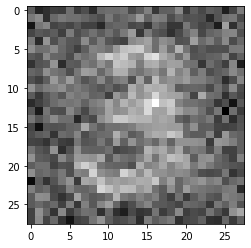

epoch : 2


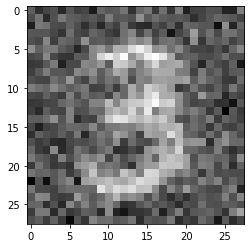

epoch : 3


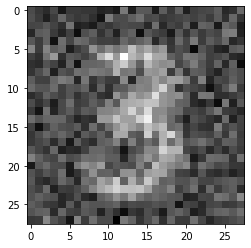

epoch : 4


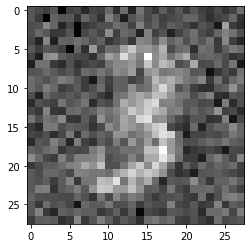

epoch : 5


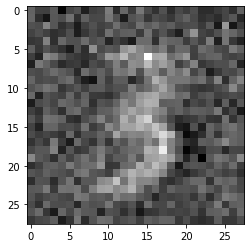

epoch : 6


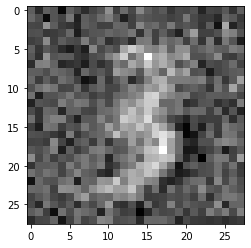

epoch : 7


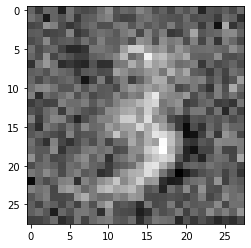

epoch : 8


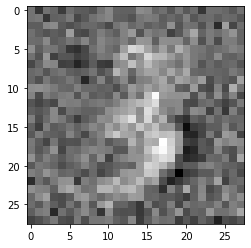

epoch : 9


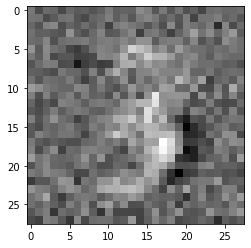

epoch : 10


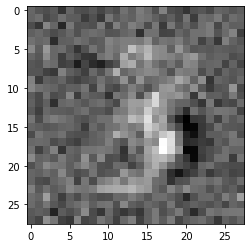

epoch : 11


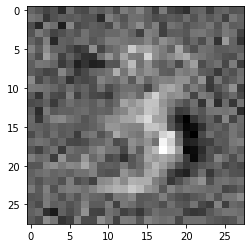

epoch : 12


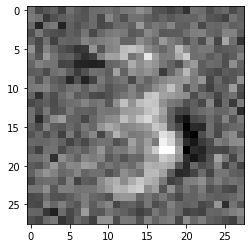

epoch : 13


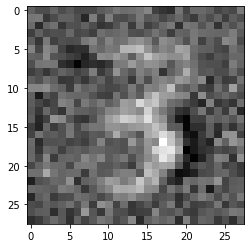

epoch : 14


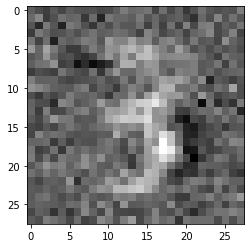

epoch : 15


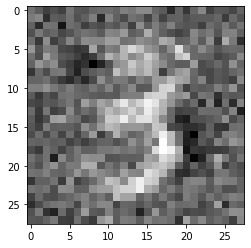

epoch : 16


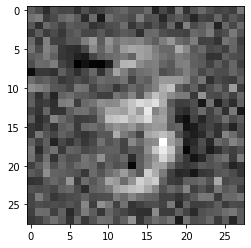

epoch : 17


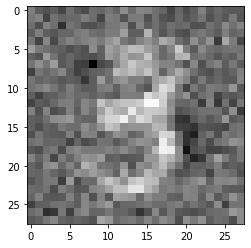

epoch : 18


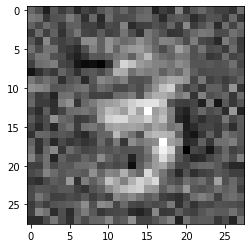

epoch : 19


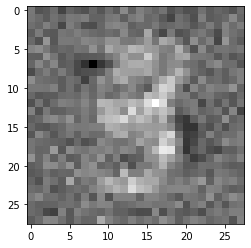

epoch : 20


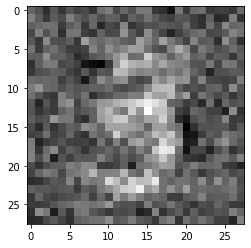

epoch : 21


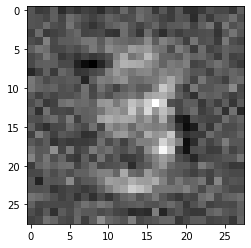

epoch : 22


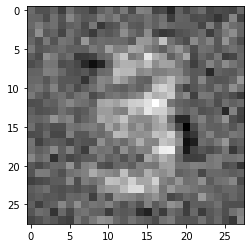

epoch : 23


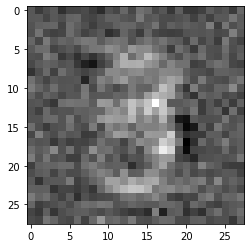

epoch : 24


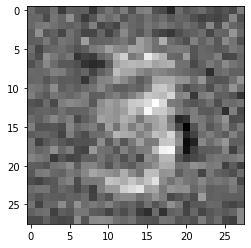

epoch : 25


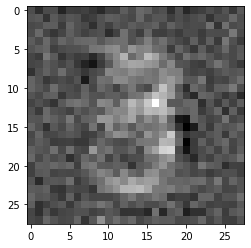

epoch : 26


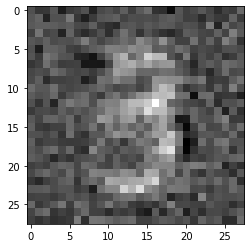

epoch : 27


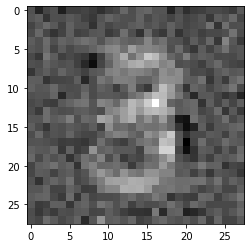

epoch : 28


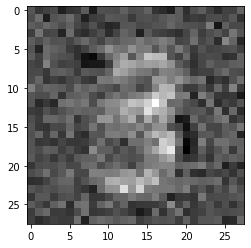

epoch : 29


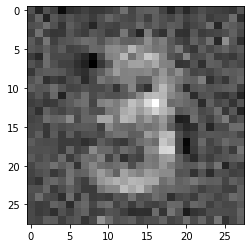

epoch : 30


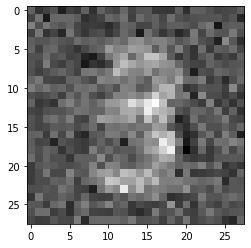

epoch : 31


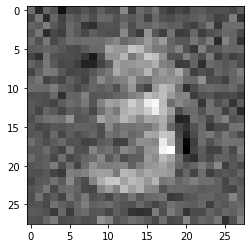

epoch : 32


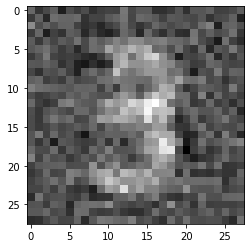

epoch : 33


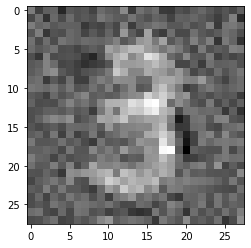

epoch : 34


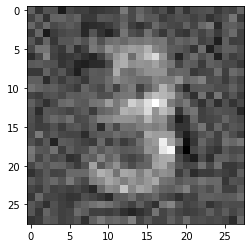

epoch : 35


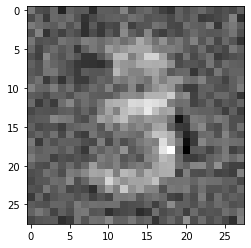

epoch : 36


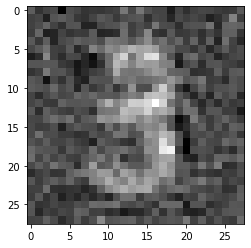

epoch : 37


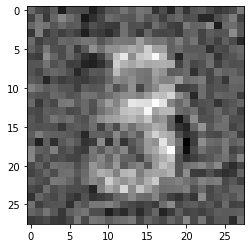

epoch : 38


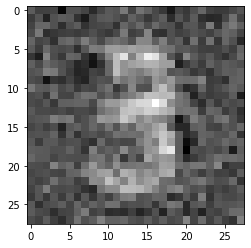

epoch : 39


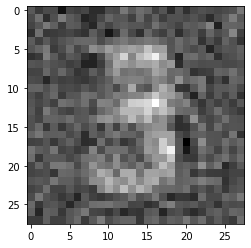

epoch : 40


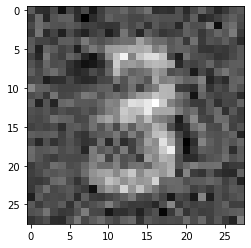

epoch : 41


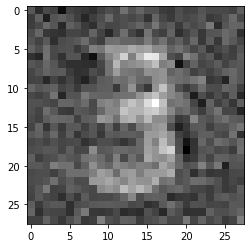

epoch : 42


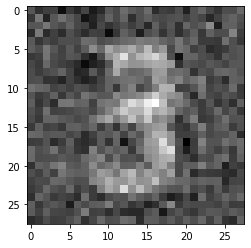

epoch : 43


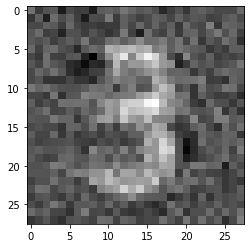

epoch : 44


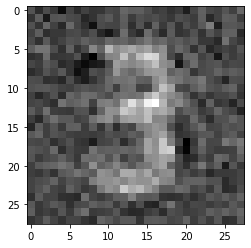

epoch : 45


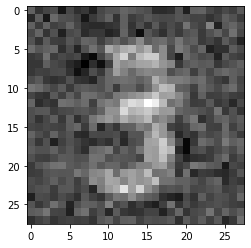

epoch : 46


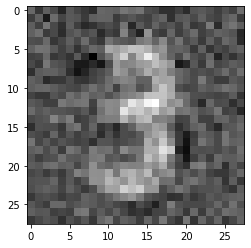

epoch : 47


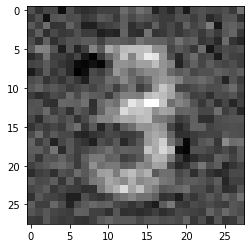

epoch : 48


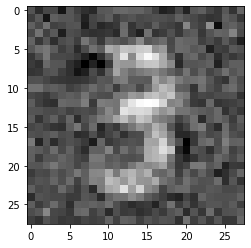

epoch : 49


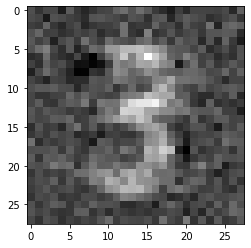

epoch : 50


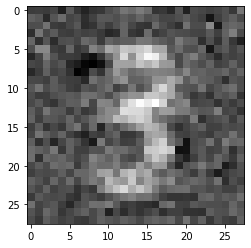

epoch : 51


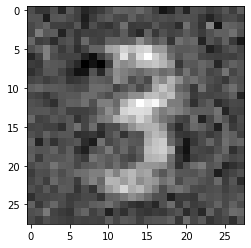

epoch : 52


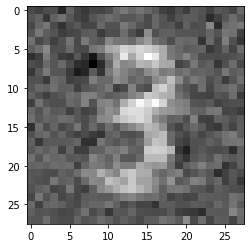

epoch : 53


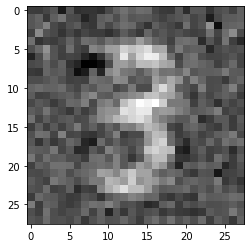

epoch : 54


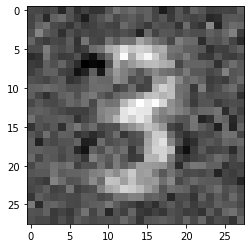

epoch : 55


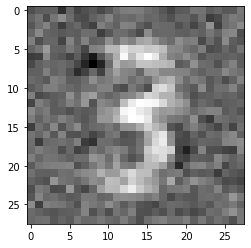

epoch : 56


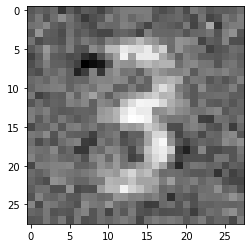

epoch : 57


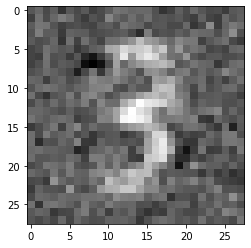

epoch : 58


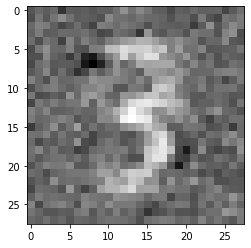

epoch : 59


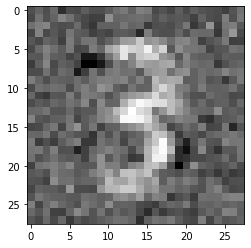

epoch : 60


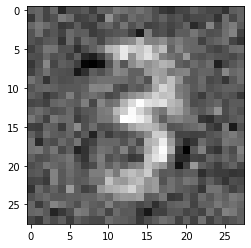

epoch : 61


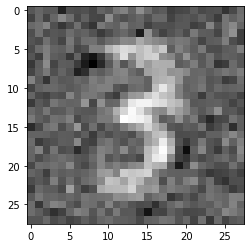

epoch : 62


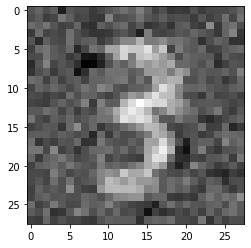

epoch : 63


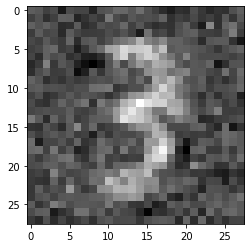

epoch : 64


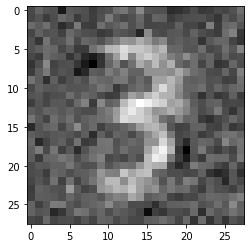

epoch : 65


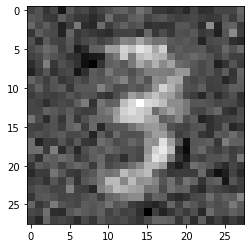

epoch : 66


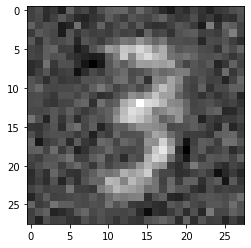

epoch : 67


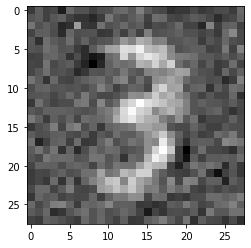

epoch : 68


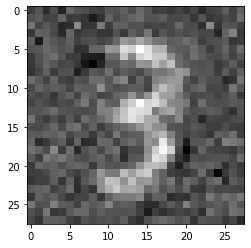

epoch : 69


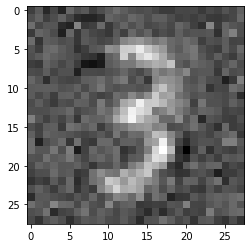

epoch : 70


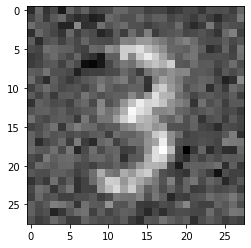

epoch : 71


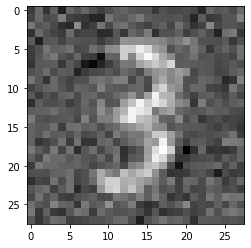

epoch : 72


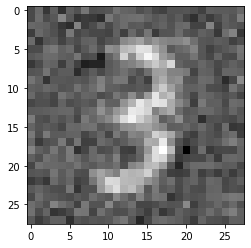

epoch : 73


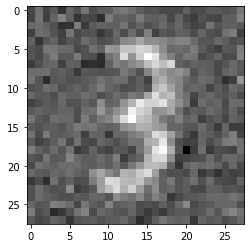

epoch : 74


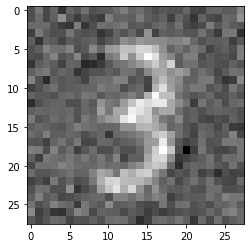

epoch : 75


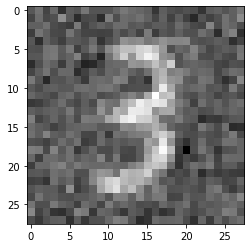

epoch : 76


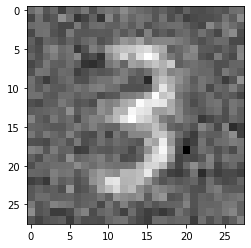

epoch : 77


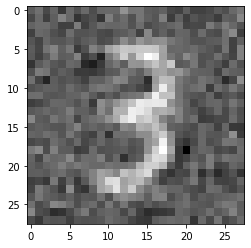

epoch : 78


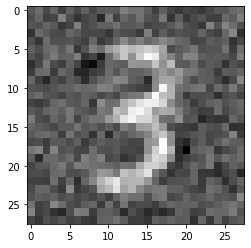

epoch : 79


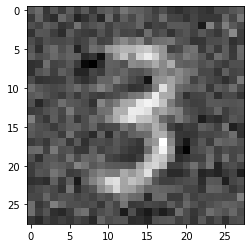

epoch : 80


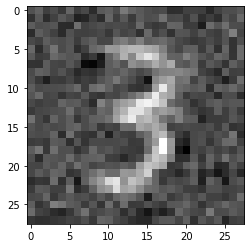

epoch : 81


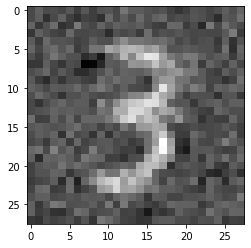

epoch : 82


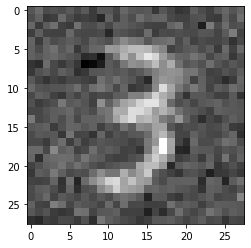

epoch : 83


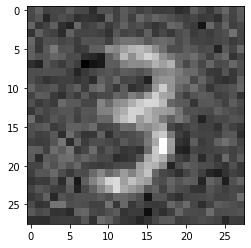

epoch : 84


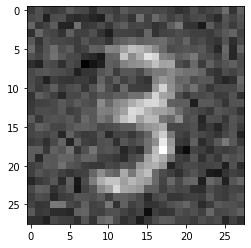

epoch : 85


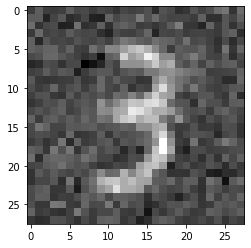

epoch : 86


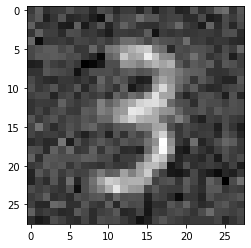

epoch : 87


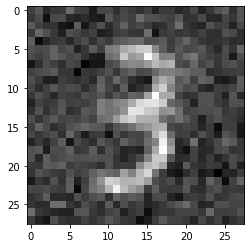

epoch : 88


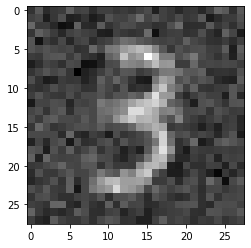

epoch : 89


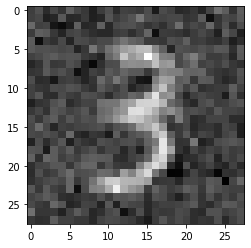

epoch : 90


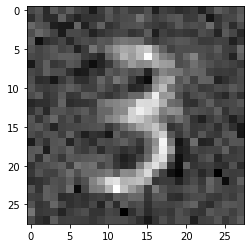

epoch : 91


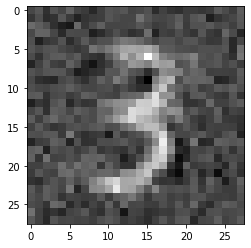

epoch : 92


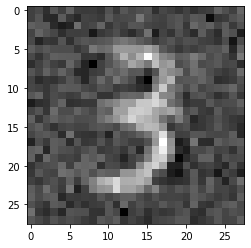

epoch : 93


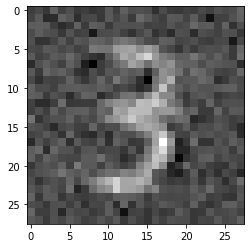

epoch : 94


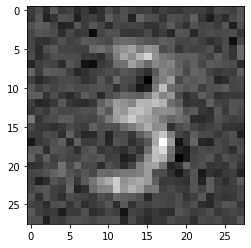

epoch : 95


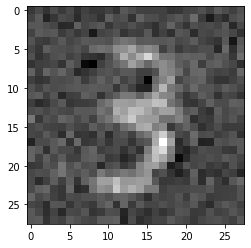

epoch : 96


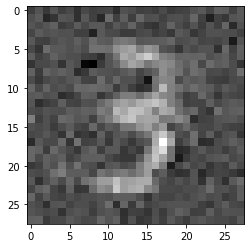

epoch : 97


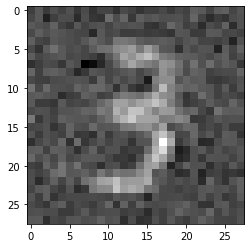

epoch : 98


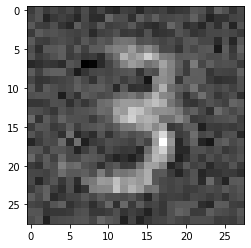

epoch : 99


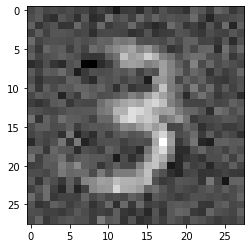

epoch : 100


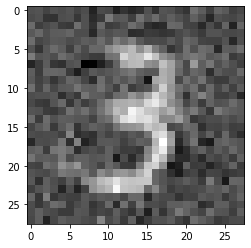

In [14]:
BATCH_SIZE = 16
NOISE_DIM = 100
EPOCHS = 100 # 500
IMG_SIZE = 28*28

# create G, D
G = Generator()
D = Discriminator()

# train
D_loss_history, G_loss_history = train(G, D, train_images, EPOCHS)


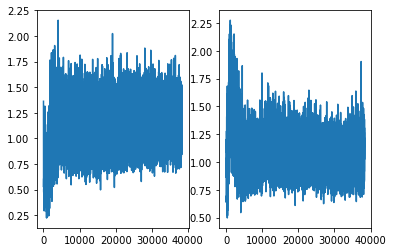

In [15]:
plt.subplot(1,2,1)
plt.plot(D_loss_history)

plt.subplot(1,2,2)
plt.plot(G_loss_history)

plt.show()